In [676]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import scipy.io as sio
from sklearn import svm, datasets

plt.style.use('fivethirtyeight')
plt.xkcd() # because why not?
np.set_printoptions(precision=3)

sns.set_context('notebook')
sns.set_style('white')

ansi = {'underline': '\033[4m', 'bold': '\033[1m', 'end':'\033[0m'}

In [626]:
def plotData(X, y):
    pos = np.argwhere(y == 1)
    neg = np.argwhere(y == 0)
    plt.figure(figsize=(10, 6))
    plt.scatter(X[pos, 0], X[pos, 1],c='k', marker='+', linewidths=0.5, label='Positive')
    plt.scatter(X[neg, 0], X[neg, 1],c='orange', marker='o', edgecolors='k',linewidths=1, label='Negative')
    plt.legend()
    plt.grid(True)

In [627]:
def linearDecisionBoundary(X, y, model):
    """Visualizes the boundary and margins of a CUSTOM linear SVM"""
    w = model.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(X[:, 0].min(), X[:, 0].max())
    yy = a * xx - (model.intercept_[0]) / w[1]

    margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
    yy_down = yy + a * margin
    yy_up = yy - a * margin
    plt.plot(xx, yy, 'orange')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

In [648]:
def contourDecisionBoundary(X, y, model, h=0.02, pad=0.25, calcGram=lambda x, y: x):
    """
    Plots a contour of a fitted SVM model, accepts an optional function calcGram
    that computes the Gram Matrix between X_mesh and X
    """
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    X_mesh = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(calcGram(X_mesh, X)).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.2)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.xlabel('X1')
    plt.ylabel('X2')

In [649]:
data = sio.loadmat('ex6data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

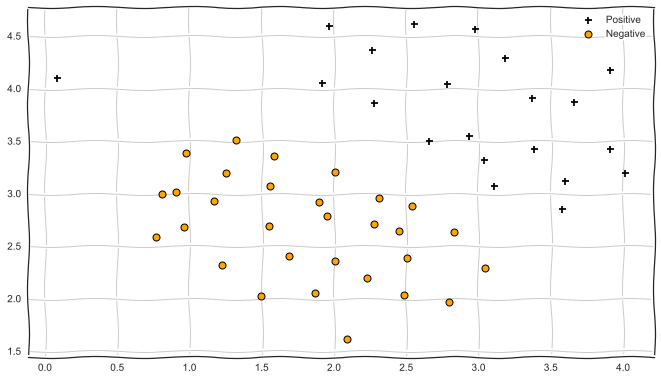

In [650]:
X = data['X']
y = data['y'].flatten()
plotData(X, y)

In [651]:
# Training a linear SVM
""" 
def linearKernel(x1, x2):
    #x1 = x1.ravel(order='F'); x2 = x2.ravel(order='F') # ensure they are column vectors
    return np.dot(x1, x2.T)

model = svm.SVC(C=1, kernel=linearKernel, tol=1e-3, max_iter=-1)
model.fit(X, y.ravel())
"""
# SVC will only output dual coefficients with a custom kernel,
# so the sklearn provided linear kernel is used

model = svm.SVC(C=1, kernel='linear')
model.fit(X, y.flatten())

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

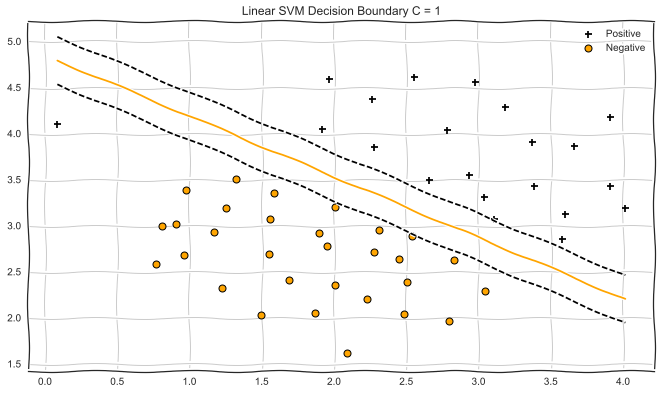

In [652]:
# Plotting decision boundary and margin of linear SVM
plotData(X, y)
linearDecisionBoundary(X, y, model)
plt.title('Linear SVM Decision Boundary C = 1')

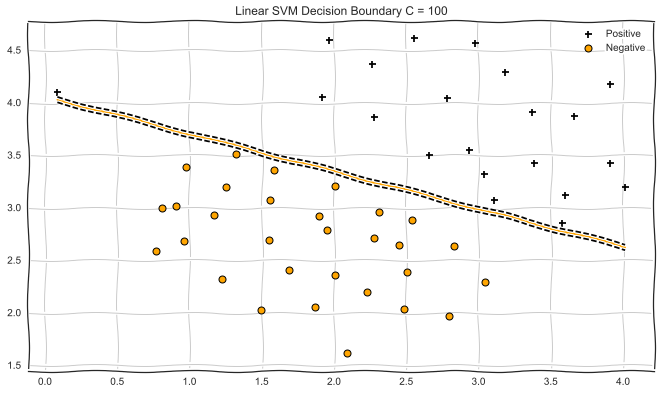

In [653]:
# Modifying decision boundary parameters
model.set_params(C=100)
model.fit(X, y.flatten())
plotData(X, y)
linearDecisionBoundary(X, y, model)
plt.title('Linear SVM Decision Boundary C = 100')

In [654]:
# Dataset 2
data = sio.loadmat('ex6data2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

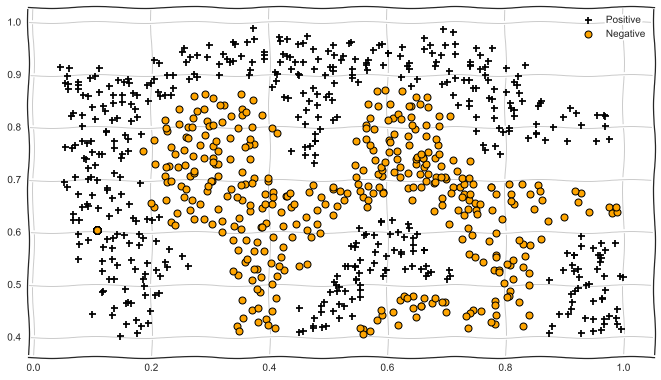

In [655]:
X = data['X']
y = data['y']
plotData(X, y)

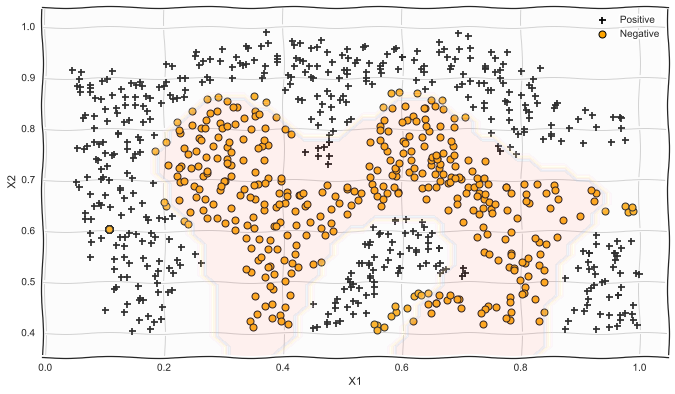

In [656]:
# Custom Gaussing Kernel with Gram Matrix
def gaussianKernel(x1, x2, sigma=0.1):
    x1 = x1.flatten(); x2 = x2.flatten()
    return np.exp(-(x1 - x2).T @ (x1 - x2) / float(2*(sigma**2)))

def gramGaussianKernel(X1, X2, K=gaussianKernel, sigma=0.1):
    """Broadcasts kernel K to X, y"""
    gram = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            gram[i, j] = K(x1, x2, sigma)
    return gram

C = 0.1
sigma = 0.1
model = svm.SVC(C=C, kernel='precomputed')
model.fit(gramGaussianKernel(X, X), y.flatten())

plotData(X, y)
contourDecisionBoundary(X, y, model, calcGram=gramGaussianKernel, pad=.05)

In [657]:
# Dataset 3
data = sio.loadmat('ex6data3.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])

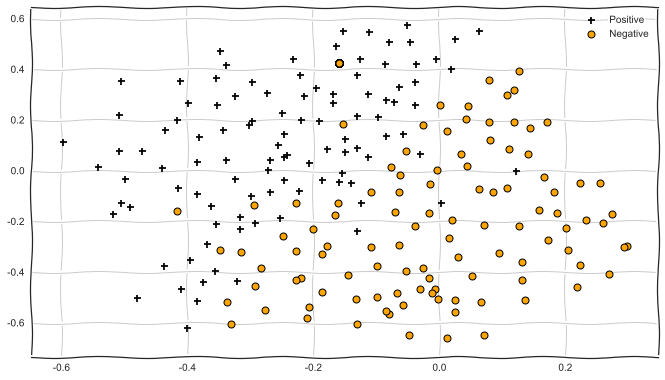

In [658]:
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']

plotData(X, y)

In [680]:
def optimizeLearningParams(X, y, Xval, yval, model):
    """Determines the best C and sigma value on the cross validation set"""
    # gamma corresponds to 1/(2sigma^2)
    C = 1
    sigma = 0.01
    error = np.inf;
    vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    print('C, sigma: Error')
    for c in vals:
        for s in vals:
            model.set_params(C=c, gamma=1/(2*s**2))
            model.fit(X, y.flatten())
            pred = model.predict(Xval)
            current_error = np.mean(pred != yval.flatten())
            if current_error < error:
                print('{0:0.3g}, {1:0.3g}: \033[1m{2:0.3g}\033[0m'.format(c, s, current_error))
                error = current_error
                C = c
                sigma = s
    return C, sigma

In [681]:
model = svm.SVC(kernel='rbf')
C, sigma = optimizeLearningParams(X, y, Xval, yval, model)
print('Minimized error with C = {2}{0}{3}, sigma = {2}{1}{3}'.format(C, sigma, ansi['bold'], ansi['end']))

model.set_params(C=C, gamma=1/(2*sigma**2))
model.fit(X, y.flatten()); # suppress output

C, sigma: Error
0.01, 0.01: 0.565
0.03, 0.1: 0.55
0.03, 0.3: 0.14
0.1, 0.1: 0.055
0.3, 0.1: 0.04
1, 0.1: 0.035
Minimized error with C = 1, sigma = 0.1


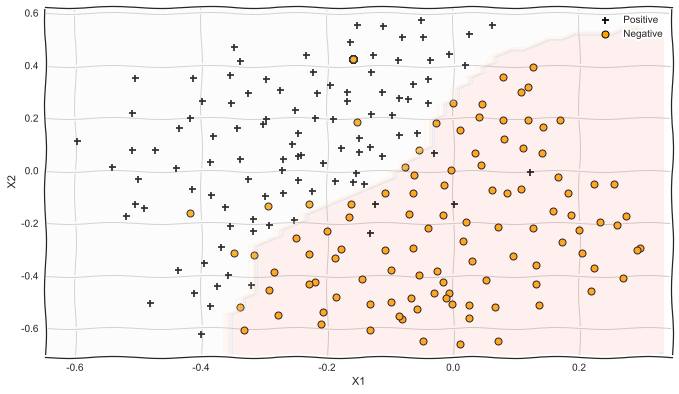

In [682]:
plotData(X, y)
contourDecisionBoundary(X, y, model, pad=0.05)